## skin lesion using mobilenet V2 - Modified

## Creating Directory

In [2]:
!pip list

Package                      Version
---------------------------- --------------
absl-py                      2.2.2
anyio                        4.9.0
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    3.0.0
astunparse                   1.6.3
async-lru                    2.0.5
attrs                        25.3.0
babel                        2.17.0
beautifulsoup4               4.13.3
bleach                       6.2.0
cattrs                       24.1.3
certifi                      2025.1.31
cffi                         1.17.1
charset-normalizer           3.4.1
comm                         0.2.2
contourpy                    1.3.1
cycler                       0.12.1
debugpy                      1.8.14
decorator                    5.2.1
defusedxml                   0.7.1
executing                    2.2.0
fastf1                       3.5.3
fastjsonschema               2.21.1
filelock                     3

In [3]:
from numpy.random import seed
seed(101)

import pandas as pd
import numpy as np
#import keras
#from keras import backend as K

import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.listdir('../input/skin-cancer-mnist-ham10000')

['hmnist_8_8_RGB.csv',
 'hmnist_28_28_RGB.csv',
 'HAM10000_images_part_1',
 'ham10000_images_part_1',
 'hmnist_8_8_L.csv',
 'HAM10000_images_part_2',
 'ham10000_images_part_2',
 'hmnist_28_28_L.csv',
 'HAM10000_metadata.csv']

In [3]:
# Create a new directory
base_dir = 'base_dir15'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 7 folders inside 'base_dir':

# train_dir
    # nv
    # mel
    # bkl
    # bcc
    # akiec
    # vasc
    # df
 
# val_dir
    # nv
    # mel
    # bkl
    # bcc
    # akiec
    # vasc
    # df

# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN, VALIDATION AND TEST FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)



# create new folders inside val_dir
nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(val_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_dir, 'df')
os.mkdir(df)

In [4]:
df_data = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
# this will tell us how many images are associated with each lesion_id
df = df_data.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000001,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1


In [6]:
# here we identify lesion_id's that have duplicate images and those that have only
# one image.

def identify_duplicates(x):
    
    unique_list = list(df['lesion_id'])
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
# create a new colum that is a copy of the lesion_id column
df_data['duplicates'] = df_data['lesion_id']
# apply the function to this new column
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates


In [7]:
df_data['duplicates'].value_counts()

duplicates
no_duplicates     5514
has_duplicates    4501
Name: count, dtype: int64

In [8]:
# now we filter out images that don't have duplicates
df = df_data[df_data['duplicates'] == 'no_duplicates']

df.shape

(5514, 8)

In [9]:
# now we create a val set using df because we are sure that none of these images
# have augmented duplicates in the train set
y = df['dx']

_, df_val = train_test_split(df, test_size=0.17, random_state=101, stratify=y)

df_val.shape

(938, 8)

In [10]:
df_val['dx'].value_counts()

dx
nv       751
bkl       75
mel       39
bcc       30
akiec     26
vasc      11
df         6
Name: count, dtype: int64

In [11]:
# This set will be df_data excluding all rows that are in the val set

# This function identifies if an image is part of the train
# or val set.
def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows

# create a new colum that is a copy of the image_id column
df_data['train_or_val'] = df_data['image_id']
# apply the function to this new column
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)
   
# filter out train rows
df_train = df_data[df_data['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))

9077
938


In [12]:
print(df_train['dx'].value_counts())
print(df_val['dx'].value_counts())

dx
nv       5954
mel      1074
bkl      1024
bcc       484
akiec     301
vasc      131
df        109
Name: count, dtype: int64
dx
nv       751
bkl       75
mel       39
bcc       30
akiec     26
vasc      11
df         6
Name: count, dtype: int64


In [13]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [ ]:
folder_1 = os.listdir('/home/subject/Desktop/HAM_10000/HAM10000_images_part_1')  # Folder containing part 1 images

folder_2 = os.listdir('/home/subject/Desktop/HAM_10000/HAM10000_images_part_2') # Folder containing part 2 images
# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transfer the train images

for image in train_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('/home/subject/Desktop/HAM_10000/HAM10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('/home/subject/Desktop/HAM_10000/HAM10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('/home/subject/Desktop/HAM_10000/HAM10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('./home/subject/Desktop/HAM_10000/HAM10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
        

In [15]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir15/train_dir/nv')))
print(len(os.listdir('base_dir15/train_dir/mel')))
print(len(os.listdir('base_dir15/train_dir/bkl')))
print(len(os.listdir('base_dir15/train_dir/bcc')))
print(len(os.listdir('base_dir15/train_dir/akiec')))
print(len(os.listdir('base_dir15/train_dir/vasc')))
print(len(os.listdir('base_dir15/train_dir/df')))

5954
1074
1024
484
301
131
109


In [16]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir15/val_dir/nv')))
print(len(os.listdir('base_dir15/val_dir/mel')))
print(len(os.listdir('base_dir15/val_dir/bkl')))
print(len(os.listdir('base_dir15/val_dir/bcc')))
print(len(os.listdir('base_dir15/val_dir/akiec')))
print(len(os.listdir('base_dir15/val_dir/vasc')))
print(len(os.listdir('base_dir15/val_dir/df')))

751
39
75
30
26
11
6


In [17]:
# note that we are not augmenting class 'nv'
class_list = ['mel','bkl','bcc','akiec','vasc','df']

for item in class_list:
    
    # We are creating temporary directories here because we delete these directories later
    # create a base dir
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir('base_dir15/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'mel'
    for fname in img_list:
            # source path to image
            src = os.path.join('base_dir15/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = 'base_dir15/train_dir/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)



    # Generate the augmented images and add them to the training folders
    
    ###########
    
    num_aug_images_wanted = 6000 # total number of images we want to have in each class
    
    ###########
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create about 6000 augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 1074 images belonging to 1 classes.
Found 1024 images belonging to 1 classes.
Found 484 images belonging to 1 classes.
Found 301 images belonging to 1 classes.
Found 131 images belonging to 1 classes.
Found 109 images belonging to 1 classes.


In [18]:
# Check how many train images we now have in each folder.
# This is the original images plus the augmented images.

print(len(os.listdir('base_dir15/train_dir/nv')))
print(len(os.listdir('base_dir15/train_dir/mel')))
print(len(os.listdir('base_dir15/train_dir/bkl')))
print(len(os.listdir('base_dir15/train_dir/bcc')))
print(len(os.listdir('base_dir15/train_dir/akiec')))
print(len(os.listdir('base_dir15/train_dir/vasc')))
print(len(os.listdir('base_dir15/train_dir/df')))

5954
5920
5920
5858
5217
5290
4410


In [19]:
# Check how many val images we have in each folder.

print(len(os.listdir('base_dir15/val_dir/nv')))
print(len(os.listdir('base_dir15/val_dir/mel')))
print(len(os.listdir('base_dir15/val_dir/bkl')))
print(len(os.listdir('base_dir15/val_dir/bcc')))
print(len(os.listdir('base_dir15/val_dir/akiec')))
print(len(os.listdir('base_dir15/val_dir/vasc')))
print(len(os.listdir('base_dir15/val_dir/df')))

751
39
75
30
26
11
6


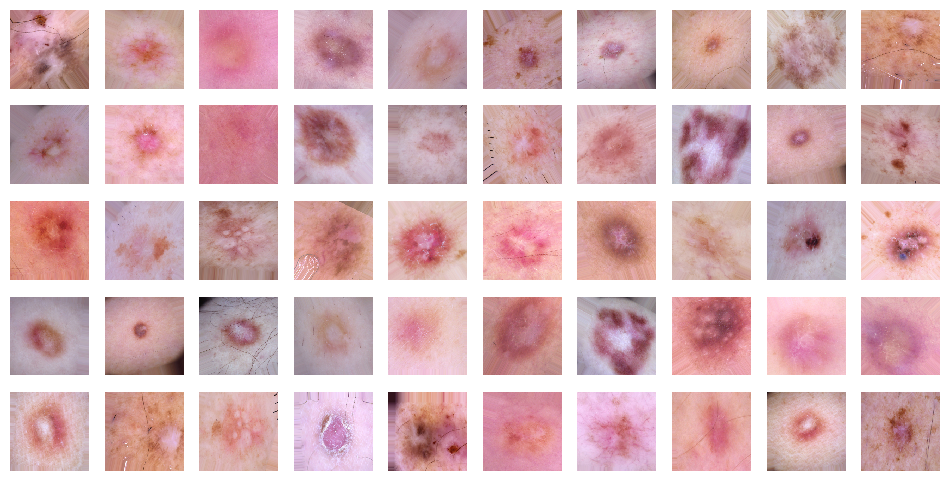

In [20]:
# plots images with labels within jupyter notebook
# source: https://github.com/smileservices/keras_utils/blob/master/utils.py

def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
plots(imgs, titles=None) # titles=labels will display the image labels

In [21]:
# Start of Model Building
train_path = 'base_dir15/train_dir'
valid_path = 'base_dir15/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 16
val_batch_size = 16
image_size = 224

train_steps =int(np.ceil((num_train_samples) / val_batch_size))
val_steps = int(np.ceil((num_val_samples) / val_batch_size))

In [22]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 38569 images belonging to 7 classes.
Found 938 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


In [23]:
# create a copy of a mobilenet model

mobile = tensorflow.keras.applications.mobilenet.MobileNet()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [24]:
mobile.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,253,864 (16.23 MB)

 Trainable params: 4,231,976 (16.14 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [25]:
print(type(mobile.layers))
print(len(mobile.layers))
from tensorflow.keras.layers import GlobalAveragePooling2D
# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-6].output
x = GlobalAveragePooling2D()(x)
# Create a new dense layer for predictions
# 7 corresponds to the number of classes
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=mobile.input, outputs=predictions)

<class 'list'>
91


In [26]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,236,039 (12.34 MB)

 Trainable params: 3,214,151 (12.26 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [27]:
# We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 23 layers in the new model.
# The last 23 layers of the model will be trained.

for layer in model.layers[:-23]:
    layer.trainable = False

In [28]:
#train

# Define Top2 and Top3 Accuracy

from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from tensorflow.keras.optimizers import Adam

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])
# Get the labels that are associated with each index
print(valid_batches.class_indices)


# Add weights to try to make the model more sensitive to melanoma

class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # mel # Try to make the model more sensitive to Melanoma.
    5: 1.0, # nv
    6: 1.0, # vasc
}

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [29]:
filepath = "model.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.0001)
                              
                             
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(
    train_batches, 
    steps_per_epoch=train_steps, 
    class_weight=class_weights,
    validation_data=valid_batches,
    validation_steps=val_steps,
    epochs=25, 
    verbose=1,
    callbacks=callbacks_list
)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


568/568 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - categorical_accuracy: 0.4928 - loss: 1.6881 - top_2_accuracy: 0.6844 - top_3_accuracy: 0.8076
Epoch 1: val_top_3_accuracy improved from -inf to 0.95949, saving model to model.keras
568/568 ━━━━━━━━━━━━━━━━━━━━ 49s 67ms/step - categorical_accuracy: 0.4930 - loss: 1.6876 - top_2_accuracy: 0.6846 - top_3_accuracy: 0.8077 - val_categorical_accuracy: 0.8422 - val_loss: 0.5029 - val_top_2_accuracy: 0.9168 - val_top_3_accuracy: 0.9595 - learning_rate: 1.0000e-04
Epoch 2/25
568/568 ━━━━━━━━━━━━━━━━━━━━ 23s 40ms/step - categorical_accuracy: 0.6971 - loss: 0.9922 - top_2_accuracy: 0.8736 - top_3_accuracy: 0.9477 - learning_rate: 1.0000e-04
Epoch 3/25
  3/568 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - categorical_accuracy: 0.7812 - loss: 0.9682 - top_2_accuracy: 0.8056 - top_3_accuracy: 0.9167

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_top_3_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_top_3_accuracy` which is not available. Available metrics are: categorical_accuracy,loss,top_2_accuracy,top_3_accuracy,learning_rate.
  callback.on_epoch_end(epoch, logs)


568/568 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - categorical_accuracy: 0.7357 - loss: 0.8629 - top_2_accuracy: 0.8952 - top_3_accuracy: 0.9614
Epoch 3: val_top_3_accuracy improved from 0.95949 to 0.97974, saving model to model.keras
568/568 ━━━━━━━━━━━━━━━━━━━━ 29s 51ms/step - categorical_accuracy: 0.7357 - loss: 0.8629 - top_2_accuracy: 0.8952 - top_3_accuracy: 0.9614 - val_categorical_accuracy: 0.8539 - val_loss: 0.4848 - val_top_2_accuracy: 0.9328 - val_top_3_accuracy: 0.9797 - learning_rate: 1.0000e-04
Epoch 4/25
568/568 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - categorical_accuracy: 0.7783 - loss: 0.7209 - top_2_accuracy: 0.9273 - top_3_accuracy: 0.9775 - learning_rate: 1.0000e-04
Epoch 5/25
138/568 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - categorical_accuracy: 0.7941 - loss: 0.6935 - top_2_accuracy: 0.9282 - top_3_accuracy: 0.9778
Epoch 5: val_top_3_accuracy improved from 0.97974 to 0.98081, saving model to model.keras
568/568 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - categorical_accuracy: 0.7890 -

In [30]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'compile_metrics']

In [31]:
# Here the the last epoch will be used.

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - categorical_accuracy: 0.7243 - loss: 1.3190 - top_2_accuracy: 0.8676 - top_3_accuracy: 0.9388
val_loss: 0.4594075083732605
val_cat_acc: 0.8912580013275146
val_top_2_acc: 0.9594882726669312
val_top_3_acc: 0.9840085506439209


In [32]:
# Here the best epoch will be used.

model.load_weights('model.keras')

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - categorical_accuracy: 0.7762 - loss: 0.7566 - top_2_accuracy: 0.8956 - top_3_accuracy: 0.9691
val_loss: 0.3512367904186249
val_cat_acc: 0.8987206816673279
val_top_2_acc: 0.9552238583564758
val_top_3_acc: 0.9850746393203735


## Plotting

dict_keys(['categorical_accuracy', 'loss', 'top_2_accuracy', 'top_3_accuracy', 'val_categorical_accuracy', 'val_loss', 'val_top_2_accuracy', 'val_top_3_accuracy', 'learning_rate'])


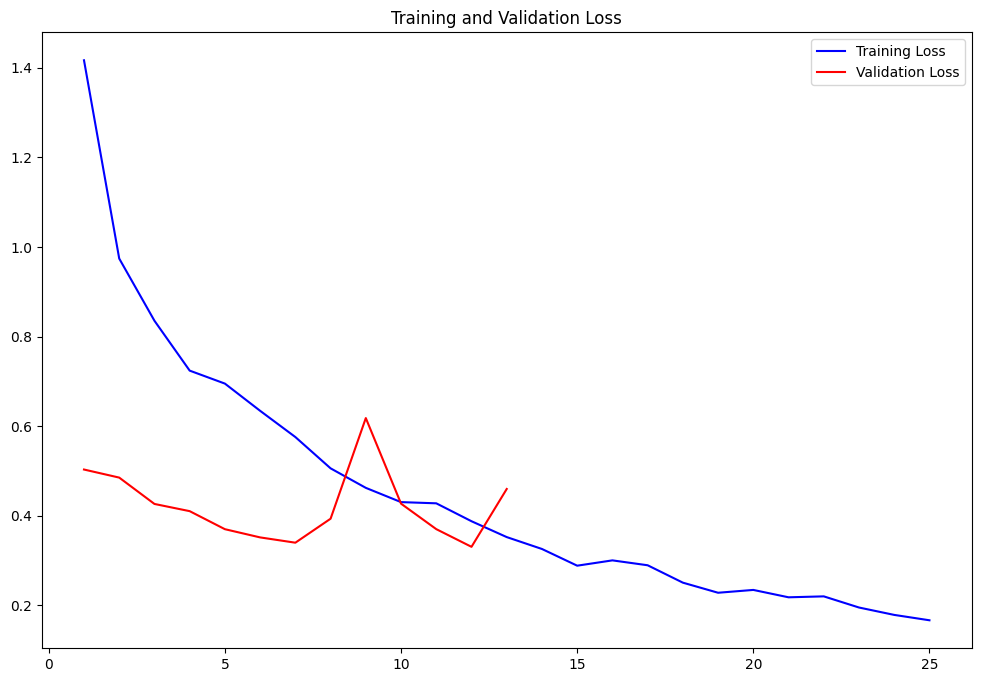

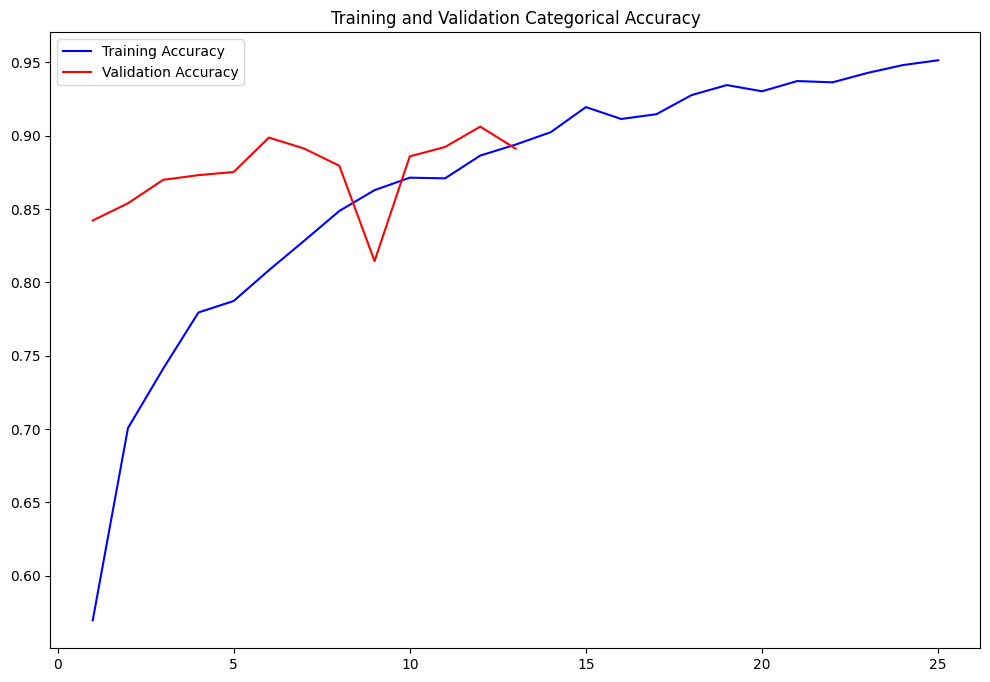

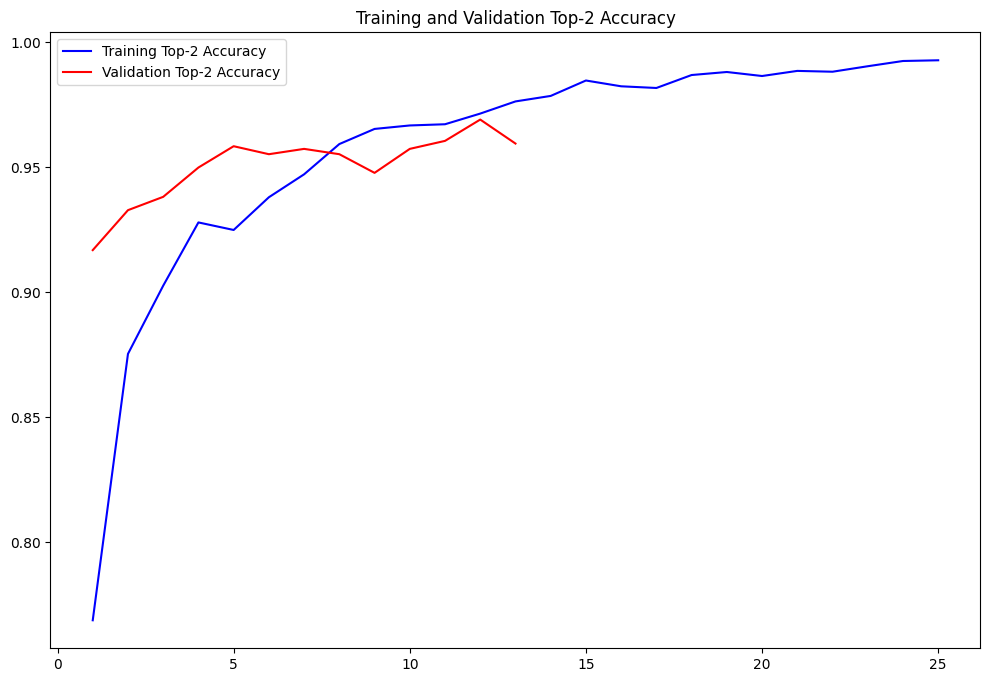

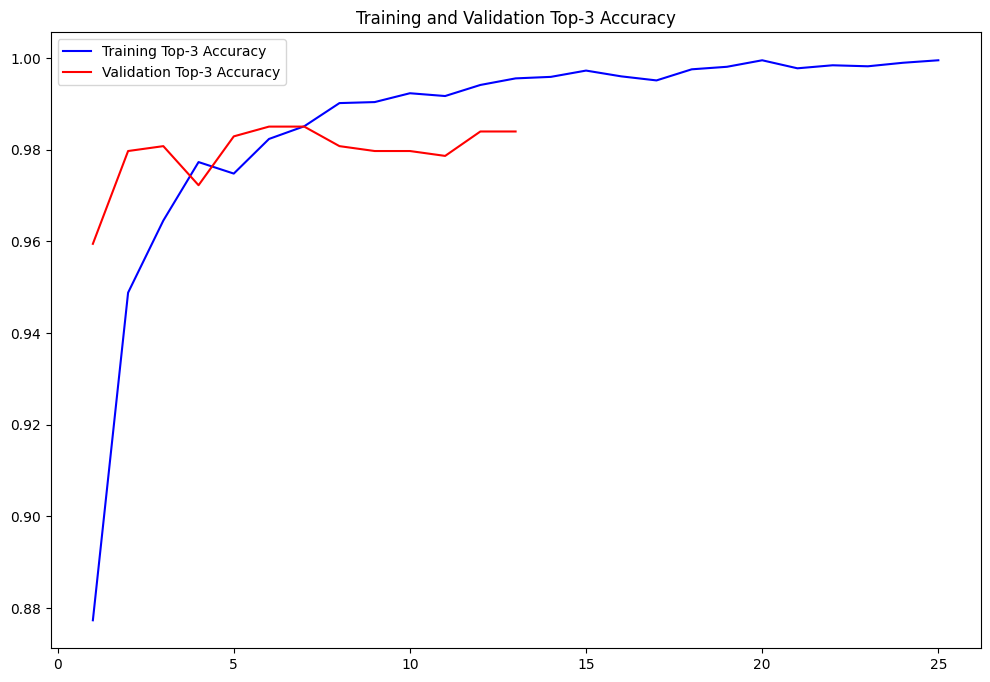

In [33]:
import matplotlib.pyplot as plt

# Check the available keys in the history object
print(history.history.keys())

# Extract metrics from history
acc = history.history.get('categorical_accuracy', [])
val_acc = history.history.get('val_categorical_accuracy', [])
loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])
train_top2_acc = history.history.get('top_2_accuracy', [])
val_top2_acc = history.history.get('val_top_2_accuracy', [])
train_top3_acc = history.history.get('top_3_accuracy', [])
val_top3_acc = history.history.get('val_top_3_accuracy', [])

# Determine the number of epochs logged
epochs = range(1, len(loss) + 1)

# Plot Loss
plt.figure(figsize=(12, 8))
plt.plot(epochs, loss, 'b', label='Training Loss')
if val_loss:
    plt.plot(epochs[:len(val_loss)], val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(12, 8))
plt.plot(epochs, acc, 'b', label='Training Accuracy')
if val_acc:
    plt.plot(epochs[:len(val_acc)], val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Categorical Accuracy')
plt.legend()
plt.show()

# Plot Top-2 Accuracy
plt.figure(figsize=(12, 8))
plt.plot(epochs, train_top2_acc, 'b', label='Training Top-2 Accuracy')
if val_top2_acc:
    plt.plot(epochs[:len(val_top2_acc)], val_top2_acc, 'r', label='Validation Top-2 Accuracy')
plt.title('Training and Validation Top-2 Accuracy')
plt.legend()
plt.show()

# Plot Top-3 Accuracy
plt.figure(figsize=(12, 8))
plt.plot(epochs, train_top3_acc, 'b', label='Training Top-3 Accuracy')
if val_top3_acc:
    plt.plot(epochs[:len(val_top3_acc)], val_top3_acc, 'r', label='Validation Top-3 Accuracy')
plt.title('Training and Validation Top-3 Accuracy')
plt.legend()
plt.show()

### Create a Confusion Matrix

In [34]:
# Get the labels of the test images.

test_labels = test_batches.classes

# We need these to plot the confusion matrix.
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [35]:
# Print the label associated with each class
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [36]:
# make a prediction
predictions = model.predict(test_batches, steps=len(df_val), verbose=1)

938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step


In [37]:
predictions.shape

(938, 7)

In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [39]:
test_labels.shape

(938,)

In [40]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

Confusion matrix, without normalization
[[ 14   1   6   0   1   4   0]
 [  1  25   1   0   0   3   0]
 [  4   0  46   0   1  24   0]
 [  0   0   0   2   0   4   0]
 [  2   1   7   0  11  18   0]
 [  4   2   8   1   1 735   0]
 [  0   0   0   0   0   1  10]]


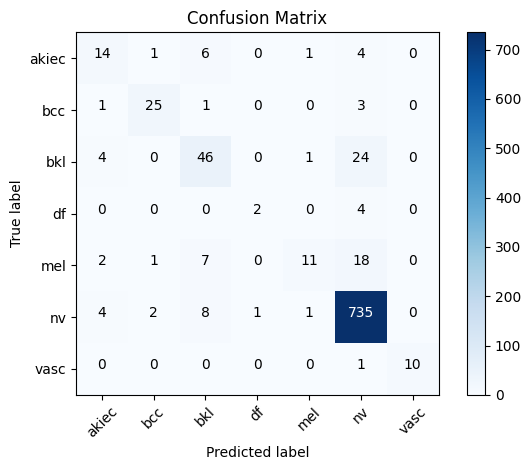

In [41]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [42]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_batches.classes

In [43]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

       akiec       0.56      0.54      0.55        26
         bcc       0.86      0.83      0.85        30
         bkl       0.68      0.61      0.64        75
          df       0.67      0.33      0.44         6
         mel       0.79      0.28      0.42        39
          nv       0.93      0.98      0.95       751
        vasc       1.00      0.91      0.95        11

    accuracy                           0.90       938
   macro avg       0.78      0.64      0.69       938
weighted avg       0.89      0.90      0.89       938

